# Restauración de imágenes con Wiener Filter

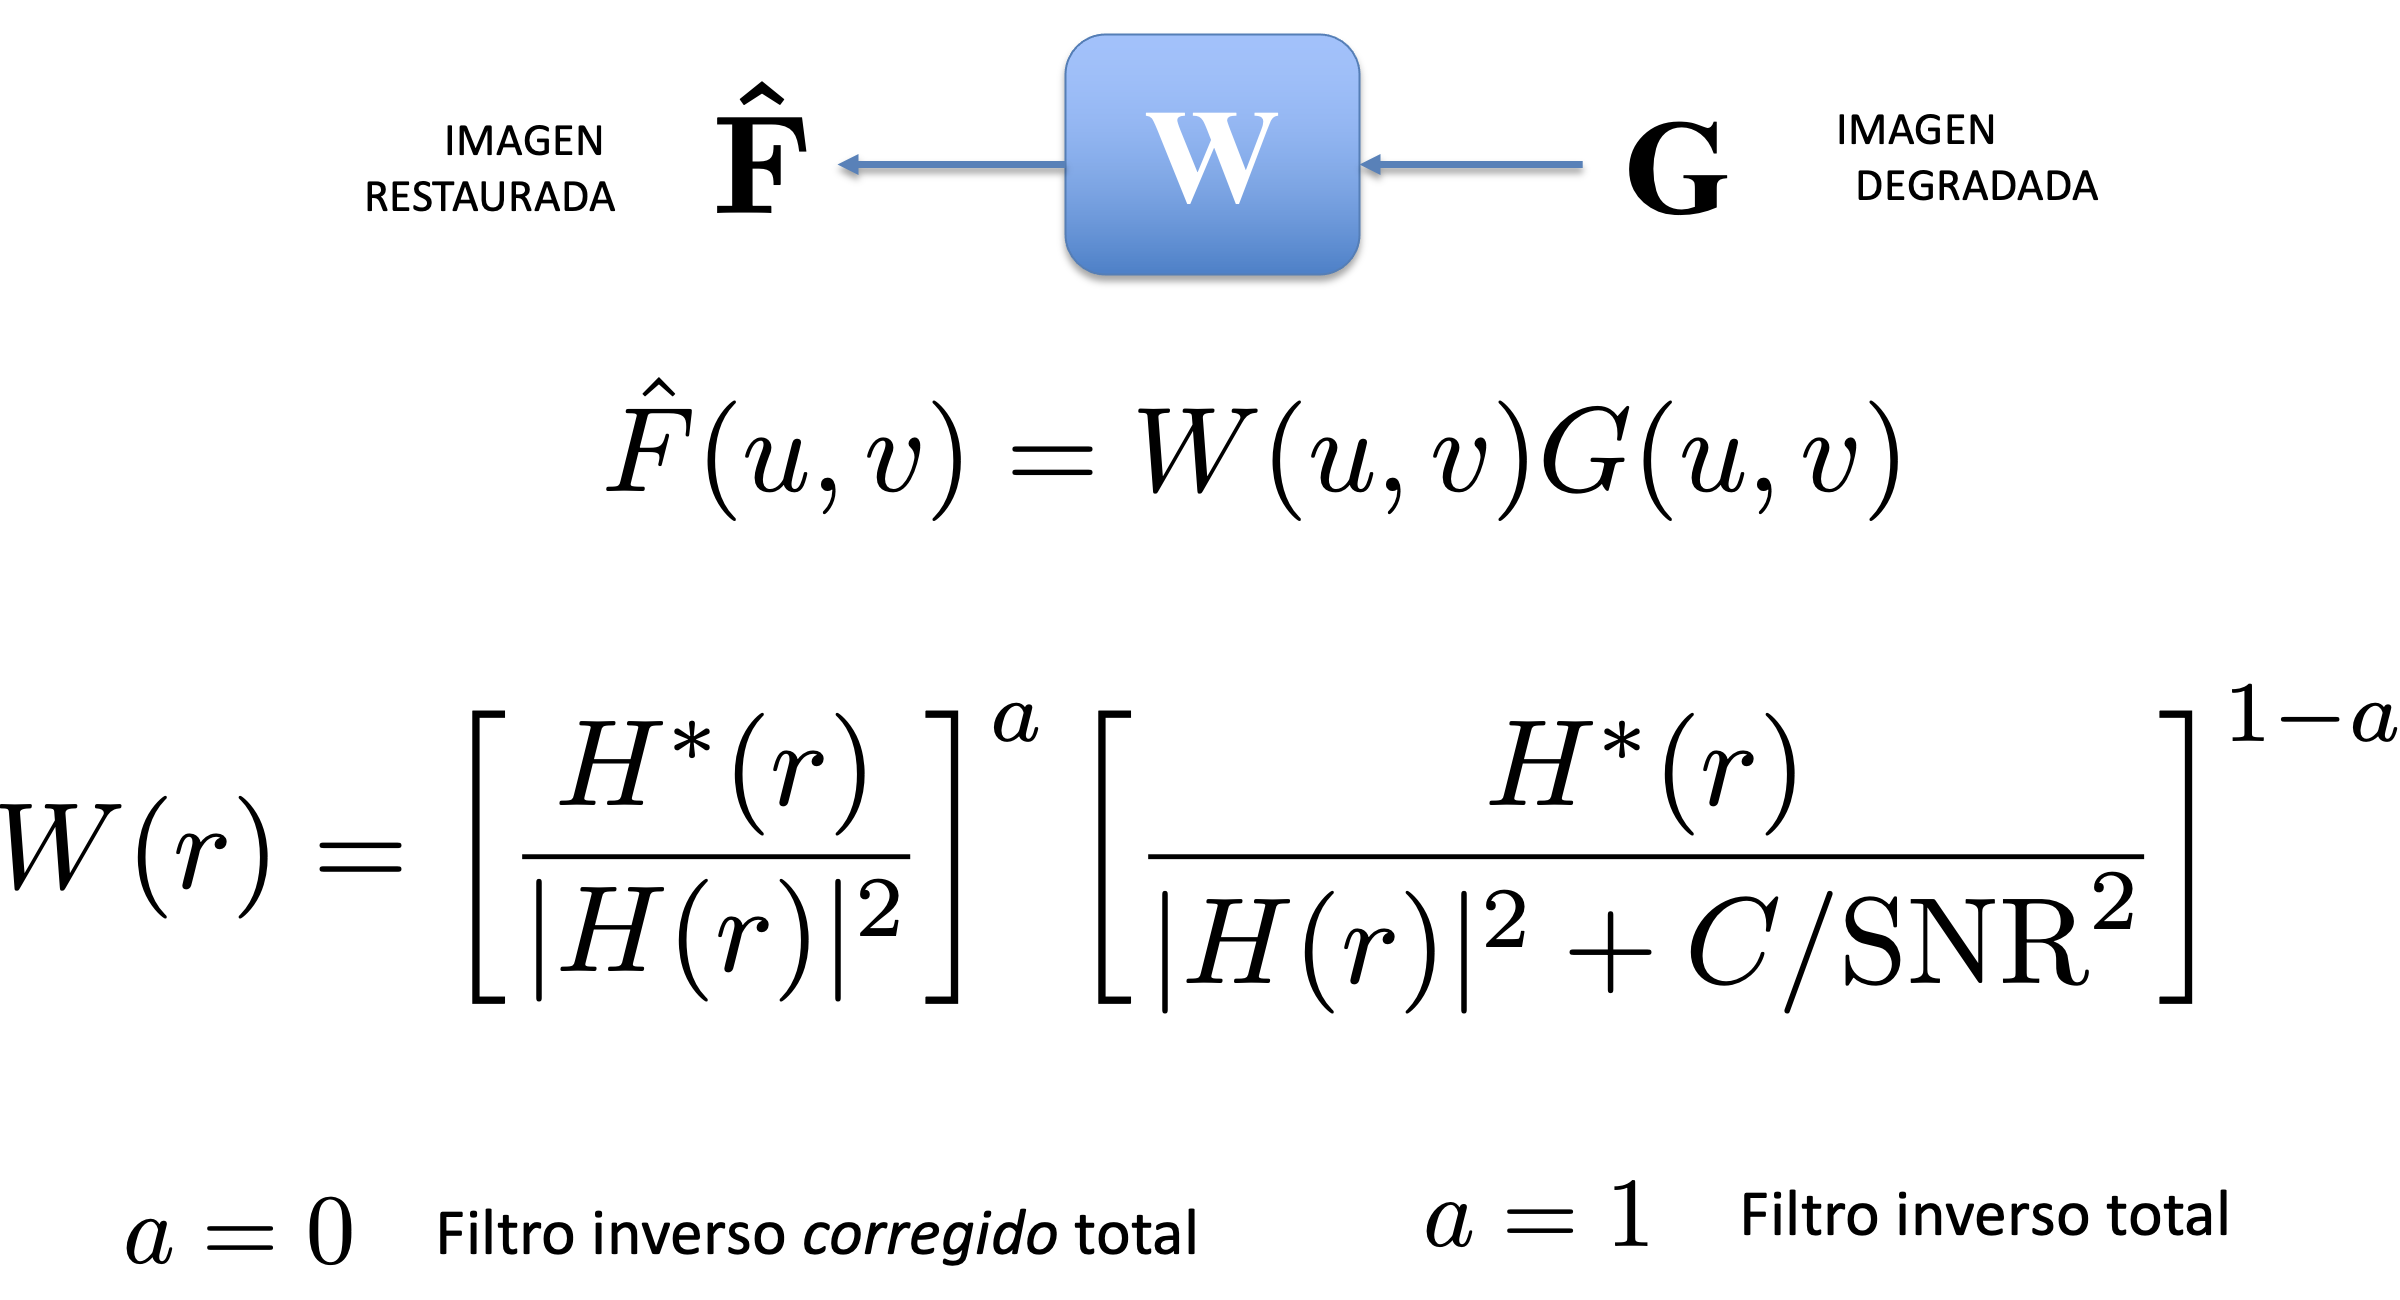

# Librerías

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from   matplotlib.colors import LogNorm
from   scipy.fftpack     import fft2,ifft2,fftshift,ifftshift


In [ ]:
!wget https://www.dropbox.com/s/sl55zs2ah19dbd0/saturn375.png?dl=0

# Imagen original ${\bf F}$

size of F: (375, 300)


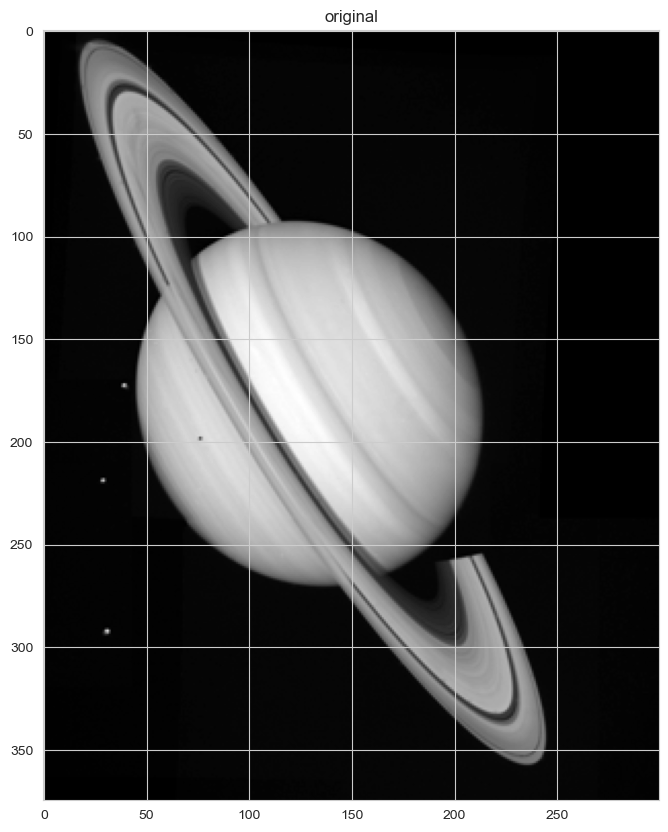

In [13]:
F = cv2.imread('saturn375.png',0)
print('size of F:',F.shape)
plt.figure(figsize=(10,10))
plt.imshow(F,cmap='gray')
plt.title('original')
plt.show()

# Simulación de Degradación

## Kernel Gaussiano

In [14]:
def gaussian_kernel(size, sigma, *args):
    """
    This method creates a symmetric Gaussian kernel.

    :param sigma: float number that defines the width of the Gaussian
            distribution
    :param size: inf number to specify the size of the kernel.
            Typical numbers 3, 5, 9, 11.
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1,
           -size // 2 + 1:size // 2 + 1]

    kernel = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    kernel = kernel / kernel.sum()

    return kernel.astype('double')


## Degradación con kernel Gaussiano

size of G: (365, 290)


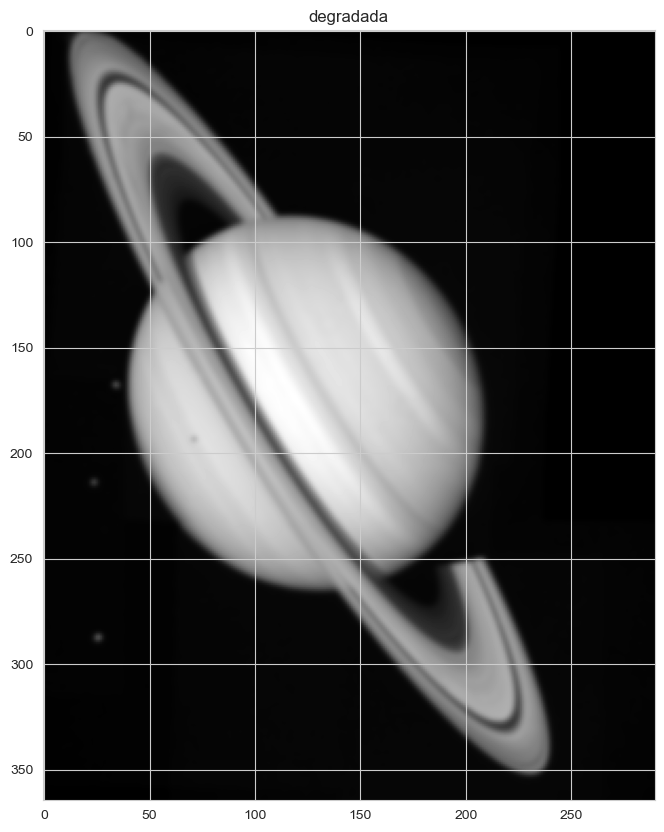

In [15]:
k = 11
s = k/8.5
m = int(k/2)
h = gaussian_kernel(k,s)
Go = cv2.filter2D(F.astype('double'), cv2.CV_64F, h) 
G = Go[m:-m,m:-m] # se toman los pixeles "válidos"
print('size of G:',G.shape)
plt.figure(figsize=(10,10))
plt.imshow(G,cmap='gray')
plt.title('degradada')
plt.show()

## Adición de ruido Gaussiano

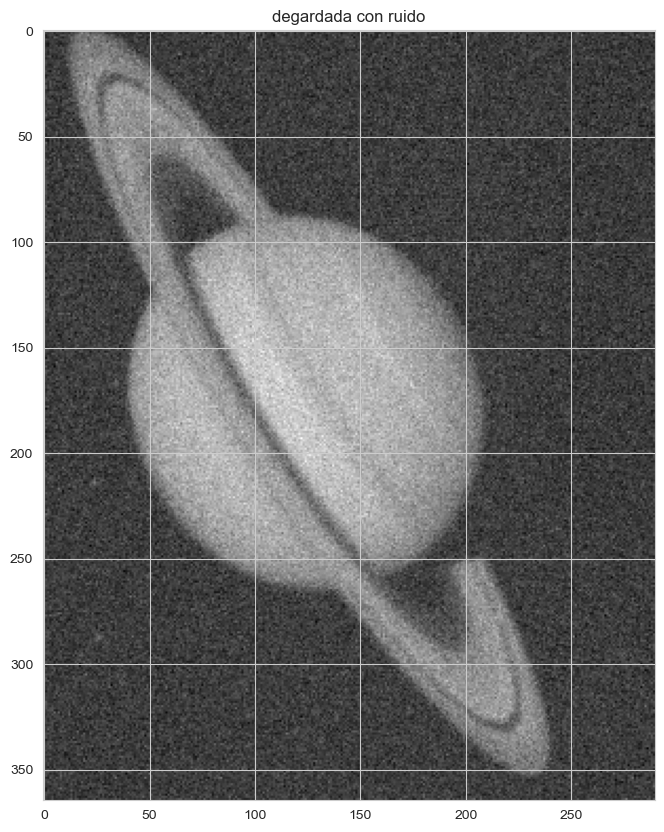

In [16]:
N,M = G.shape
A = 20 # magnitud del ruido
R = A*np.random.randn(N,M)
Gr = G.astype('double')+R
plt.figure(figsize=(10,10))
plt.imshow(Gr,cmap='gray')
plt.title('degardada con ruido')
plt.show()

# Restuarción

In [17]:
def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

def plot_spectrum(X_ft,centered=True):
    # A logarithmic colormap
    if centered:
      X_ftc = fftshift(X_ft)
    else:
      X_ftc = X_ft
    plt.imshow(np.abs(X_ftc), norm=LogNorm(vmin=5))
    plt.colorbar()


## Definciones

In [18]:
C   = 0.0251
rho = 0.05
a   = 0.5

In [19]:
N,M = G.shape
n,m = h.shape
N2  = 2*(N+n-1)
M2  = 2*(M+m-1)

## Definición de C/SNR^2

376.0 301.0
0.03418297399942487


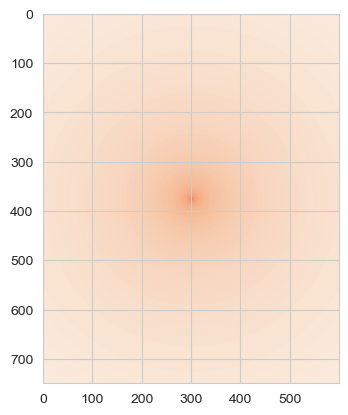

In [20]:
# SNR2inv(r) = C*r^rho
SNR2inv = np.zeros((N2,M2))
n2 = N2/2+1
m2 = M2/2+1
print(n2,m2)
for i in range(N2):
  for j in range(M2):
    SNR2inv[i,j] = C*np.sqrt((i-n2)**2+(j-m2)**2)**rho

plt.imshow(SNR2inv)
print(np.max(SNR2inv))

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: >,
 <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x23cb867d250>)

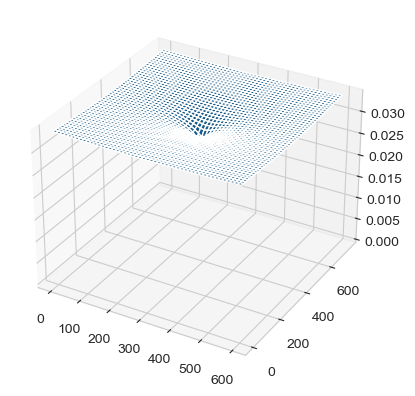

In [21]:
surface_plot(SNR2inv)

## Cómputo final

size of Fs: (375, 300)


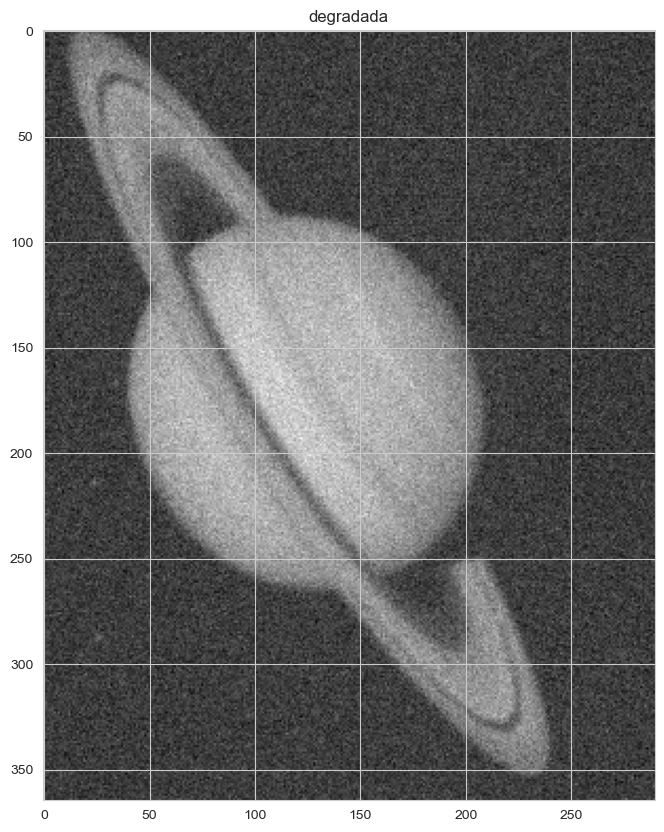

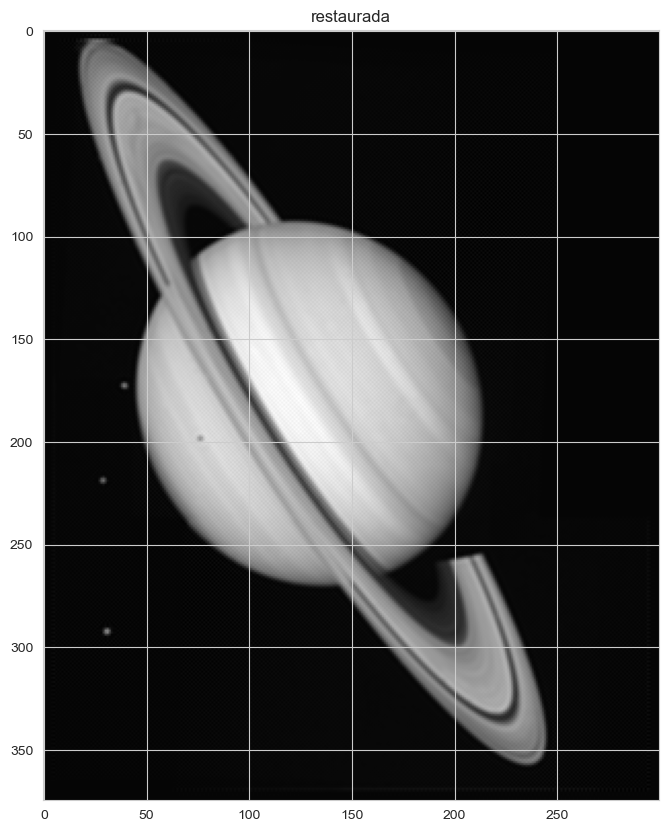

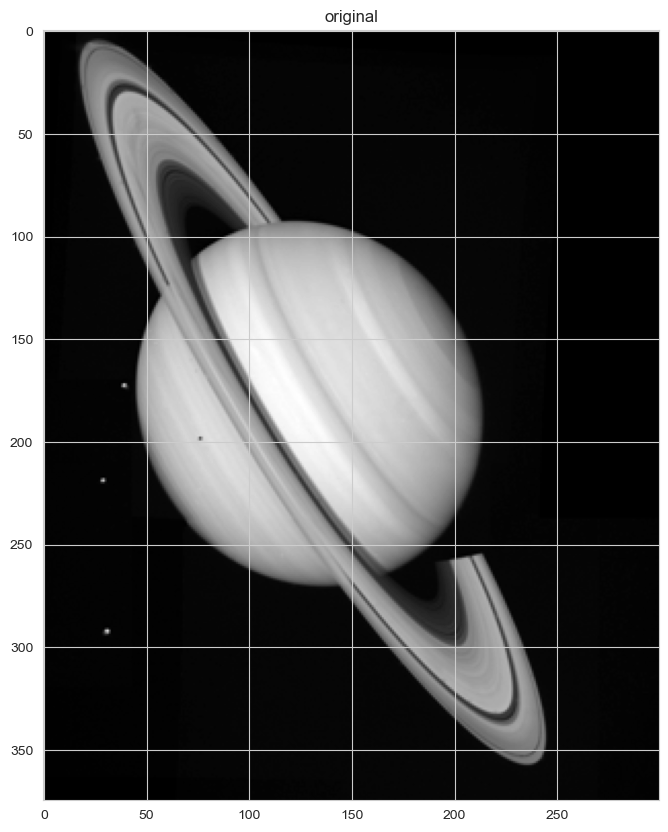

In [22]:
Ge              = np.zeros((N2,M2))
Ge[n:N+n,m:M+m] = G
He              = np.zeros((N2,M2))
He[0:n,0:m]     = h


FG   = fft2(Ge)
FH   = fft2(He)
AFH  = np.abs(FH)
AFH2 = np.multiply(AFH,AFH)

# Primer operando (^a)
W1   = (np.divide(np.conj(FH),AFH2))**a

# Segundo operando (^(1-a))
D2   = AFH2 + SNR2inv # denominador
W2   = np.divide(np.conj(FH),D2)**(1-a)

# Multiplicación
W    = np.multiply(W1,W2)
FFs  = np.multiply(W,FG)

Fs   = np.abs(ifft2(FFs))

Ns = N+n-1
Ms = M+m-1
k=1
Fs = Fs[k:k+Ns,k:k+Ms]
print('size of Fs:',Fs.shape)

plt.figure(figsize=(10,10))
plt.imshow(Gr,cmap='gray')
plt.title('degradada')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(Fs,cmap='gray')
plt.title('restaurada')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(F,cmap='gray')
plt.title('original')
plt.show()